In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import joblib

In [127]:
#Load in datasets.
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

#Test set.
df_test = pd.read_csv('test.csv')

### Feature Engineering

In [128]:
#adds classification column.
fake['classification'] = 0 
true['classification'] = 1

#Merge dataset and title + text column.
merged = pd.concat([true,fake]).reset_index(drop = True)
merged['combined_text'] = merged['title'] + ' ' + merged['text']
df_test['text'] = df_test['title'] + ' ' + df_test['text'] 

#Reverse labeling of articles to match training set labeling.
df_test.label = 1-df_test.label

In [129]:
#Check for null values in train/validation set.
merged.isnull().sum() 

title             0
text              0
subject           0
date              0
classification    0
combined_text     0
dtype: int64

In [131]:
#Removing rows where the articles have null values.
df_test = df_test[df_test['text'].notna()]
df_test.reset_index(drop=True,inplace=True)
df_test.isnull().sum()

id           0
title        0
author    1918
text         0
label        0
dtype: int64

### Text preprocessing

In [132]:
#Word tokenizer.
tokenizer = nltk.tokenize.TreebankWordTokenizer()

#Stopwords removal.
stop_words = set(stopwords.words('english'))

# Word Normalization
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(text_col):
    for i in range(len(text_col)):
        re.sub(r"http\S+", "",text_col[i])
        text_col[i] = tokenizer.tokenize(text_col[i])
        text_col[i] = [token for token in text_col[i] if token not in stop_words]
        text_col[i] = [lemmatizer.lemmatize(token) for token in text_col[i]]
        text_col[i] = " ".join([char for char in text_col[i] if char.isalpha()])
        
preprocess_text(merged['combined_text'])
preprocess_text(df_test['text'])

<ipython-input-132-beef1dd8275b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_col[i] = tokenizer.tokenize(text_col[i])
<ipython-input-132-beef1dd8275b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_col[i] = [token for token in text_col[i] if token not in stop_words]
<ipython-input-132-beef1dd8275b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_col[i] = [lemmatizer.lemmatize(token) for token in text_col[i]]
<

### Exploratory Data Analysis

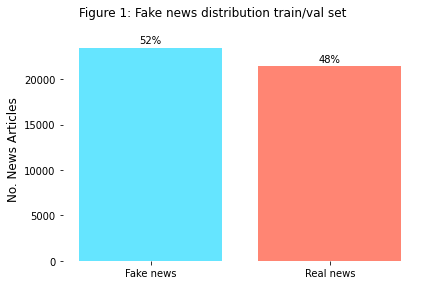

In [184]:
#Total amount of articles in train/validation set.
total = len(true) + len(fake)

#plots
figure, axes = plt.subplots()
plt.bar('Fake news',len(fake),color=(0, 213/255,1, 0.6))
plt.bar('Real news', len(true),color=(1, 34/255, 0, 0.55))
plt.ylabel('No. News Articles', size=12)
figure.suptitle('Figure 1: Fake news distribution train/val set')

#Remove axis.
axes.set_frame_on(False)
axes.yaxis.set_visible(True)

#Display percentages.
for p in axes.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes.annotate(f'{height / total:.0%}', (x + width/2, y + height*1.02), ha='center')
    
figure.tight_layout()
plt.show()

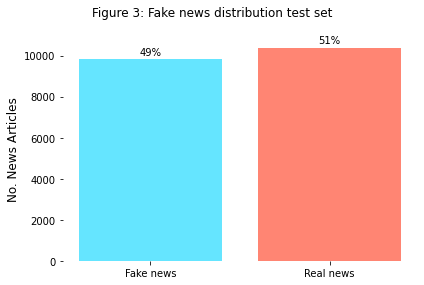

In [181]:
#plots
figure, axes = plt.subplots()
plt.bar('Fake news',len(df_test[df_test['label'] == 0]),color=(0, 213/255,1, 0.6))
plt.bar('Real news', len(df_test[df_test['label'] == 1]),color=(1, 34/255, 0, 0.55))
plt.ylabel('No. News Articles', size=12)
figure.suptitle('Figure 3: Fake news distribution test set')

#Remove axis.
axes.set_frame_on(False)
axes.yaxis.set_visible(True)

#Display percentages.""
for p in axes.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes.annotate(f'{height / len(df_test):.0%}', (x + width/2, y + height*1.02), ha='center')
    
figure.tight_layout()
plt.show()

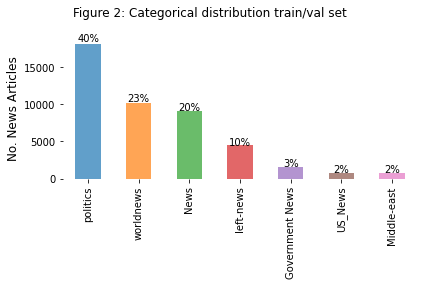

In [183]:
#Translating identical subjects to have the same notation.
merged.subject = merged.subject.replace({'politicsNews':'politics'})

#Plots.
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2']
figure, axes = plt.subplots()
merged['subject'].value_counts().plot.bar(color = colors, alpha=0.7)
figure.suptitle('Figure 2: Categorical distribution train/val set ')

#Remove axis
axes.set_frame_on(False)
axes.yaxis.set_visible(True)

#Label
plt.ylabel('No. News Articles', size=12)

#Display percentages.
for p in axes.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes.annotate(f'{height / len(merged):.0%}', (x + width/2, y + height*1.02), ha='center')

figure.tight_layout()
plt.show()


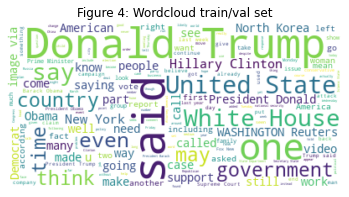

In [185]:
#Generate wordcloud train/validation set.
fake_articles = merged['combined_text']
wordcloud2 = WordCloud(background_color='white').generate(' '.join(fake_articles))

# Display the generated image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Figure 4: Wordcloud train/val set')
plt.axis("off")
plt.show()

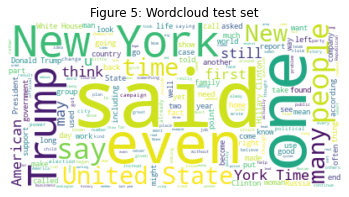

In [186]:
#Generate wordcloud test set.
test_articles = df_test['text']
wordcloud2 = WordCloud(background_color='white').generate(' '.join(test_articles))

# Display the generated image:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Figure 5: Wordcloud test set')
plt.axis("off")
plt.show()

### Train classifier

In [160]:
#Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(merged.combined_text, merged.classification, test_size = 0.2,random_state=0)

#Vectorizing the datasets.
vectorizer = TfidfVectorizer(lowercase=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

#Fitting the model
model = LogisticRegression(C=1e50)
model.fit(train_vectors, y_train)

LogisticRegression(C=1e+50)

### Results: Validation set

Text(0.5, 42.0, 'Predicted')

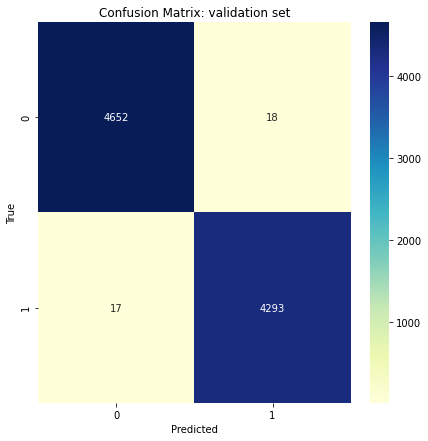

In [187]:
predicted_value = model.predict(test_vectors)

#Format predictions.
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

#Plot confusion matrix.
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True,fmt='g',cmap="YlGnBu")
plt.title('Confusion Matrix: validation set')
plt.ylabel('True')
plt.xlabel('Predicted')

In [178]:
#Measuring overall accuracy.
accuracy_value = roc_auc_score(y_test, predicted_value)
print("ROC-AUC:",accuracy_value)

ROC-AUC: 0.9961006473665643


In [163]:
#Measuring Specificity
TN = cm[0][0]
print("Specificity: ", TN/ (y_test == 0).sum())

Specificity:  0.9961456102783726


### Results: Test set

Text(0.5, 42.0, 'Predicted')

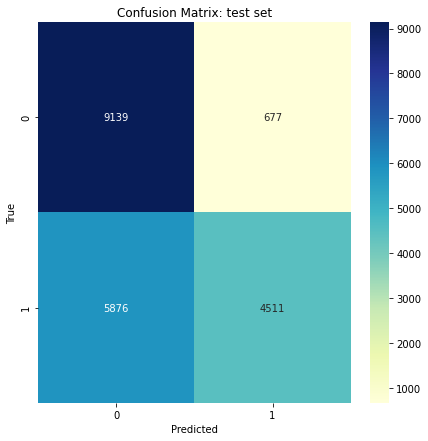

In [179]:
predicted_value = model.predict(vectorizer.transform(df_test['text']))

#Format predictions.
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

#Plot confusion matrix.
cm = confusion_matrix(list(df_test['label']), prediction)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True,fmt='g',cmap="YlGnBu")
plt.title('Confusion Matrix: test set')
plt.ylabel('True')
plt.xlabel('Predicted')

In [175]:
#Measuring overall accuracy.
accuracy_value = roc_auc_score(df_test['label'], predicted_value)

print("ROC-AUC:",accuracy_value)

ROC-AUC: 0.6826619179638771


In [166]:
#Measuring Specificity.
TN = cm[0][0]
print("Specificity: ", TN/ len(df_test[df_test['label'] == 0]))

Specificity:  0.9310309698451508


### Save model

In [167]:
# save the model to disk
filename = 'fakenews_classifier.sav'
joblib.dump(model, filename)

#save vectorizer
filename2 = 'finalized_countvectorizer.sav'
joblib.dump(vectorizer, filename2)

['finalized_countvectorizer.sav']